In [1]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, precision_score, classification_report
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import GridSearchCV
import pickle
from collections import Counter
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
def load_mel_spectrograms_from_h5(file_path):
    try:
        with h5py.File(file_path, "r") as h5_file:
            print(h5_file.keys())
            X = h5_file['X']
            y = h5_file['y']
            return np.array(X), np.array(y)
    except:
        print("Lỗi trong quá trình load dữ liệu từ file!")

In [3]:
def show_counts_labels(y):
    labels, counts = np.unique(y, return_counts=True)
    for label, count in zip(labels, counts):
        print(f"Nhãn: {label}, Số lượng: {count}")


def visualize_counts_labels(y):
    counts = Counter(y)
    labels = list(counts.keys())
    values = list(counts.values())
    labels_name = {0 : "Sáo", 1 : "Trumpet", 2 : "Guitar", 3 : "Saxo", 4 : "Piano", 5 : "Trống", 6 : "Vio"}
    labels_new = [labels_name.get(label, str(label)) for label in labels]

    plt.figure(figsize=(8, 5))
    plt.bar(labels_new, values, color='skyblue')
    plt.xlabel('Nhãn')
    plt.ylabel('Số lượng')
    plt.title('Số lượng từng nhãn trong tập dữ liệu')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [4]:
file_path = r"D:\Tài liệu học đại học\ProjectML\processed_data.h5"
X, y = load_mel_spectrograms_from_h5(file_path)
print(X.shape, y.shape)

<KeysViewHDF5 ['X', 'y']>
(7000, 16640) (7000,)


In [5]:
show_counts_labels(y)

Nhãn: 0, Số lượng: 1000
Nhãn: 1, Số lượng: 1000
Nhãn: 2, Số lượng: 1000
Nhãn: 3, Số lượng: 1000
Nhãn: 4, Số lượng: 1000
Nhãn: 5, Số lượng: 1000
Nhãn: 6, Số lượng: 1000


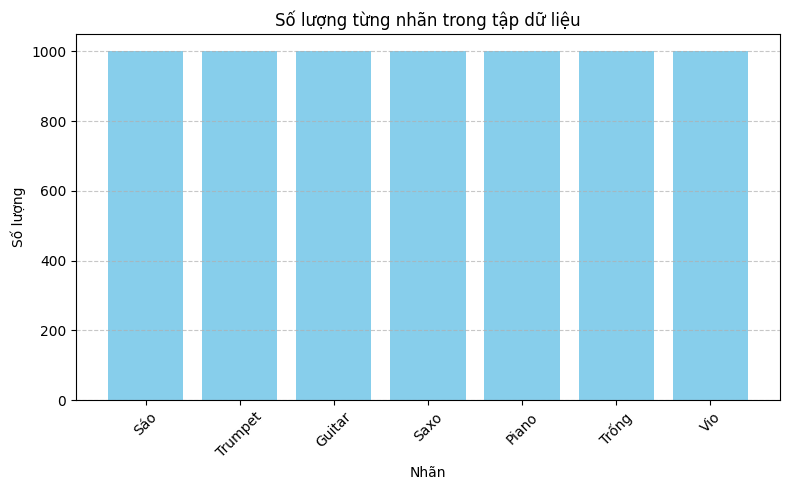

In [6]:
visualize_counts_labels(y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
) #stratify để đảm bảo sau khi chia số lượng nhãn của mỗi loại vẫn bằng nhau

In [8]:
print("Train:")
show_counts_labels(y_train)
print("________________________")
print("Test")
show_counts_labels(y_test)

Train:
Nhãn: 0, Số lượng: 800
Nhãn: 1, Số lượng: 800
Nhãn: 2, Số lượng: 800
Nhãn: 3, Số lượng: 800
Nhãn: 4, Số lượng: 800
Nhãn: 5, Số lượng: 800
Nhãn: 6, Số lượng: 800
________________________
Test
Nhãn: 0, Số lượng: 200
Nhãn: 1, Số lượng: 200
Nhãn: 2, Số lượng: 200
Nhãn: 3, Số lượng: 200
Nhãn: 4, Số lượng: 200
Nhãn: 5, Số lượng: 200
Nhãn: 6, Số lượng: 200


### Tiến hành StandardScaler

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Tiến hành giảm số chiều bằng PCA (Dành cho SVM và KNN)

In [15]:
pca = IncrementalPCA()
pca.fit(X_train_scaled)

IncrementalPCA()

In [9]:
def graphs_phuong_sai(phuong_sai):
    plt.plot(range(1, len(phuong_sai) + 1), phuong_sai)
    plt.xlabel("Số thành phần chính")
    plt.ylabel("Tỷ lệ phương sai giải thích")
    plt.title("Tỷ lệ phương sai PCA")
    plt.show()

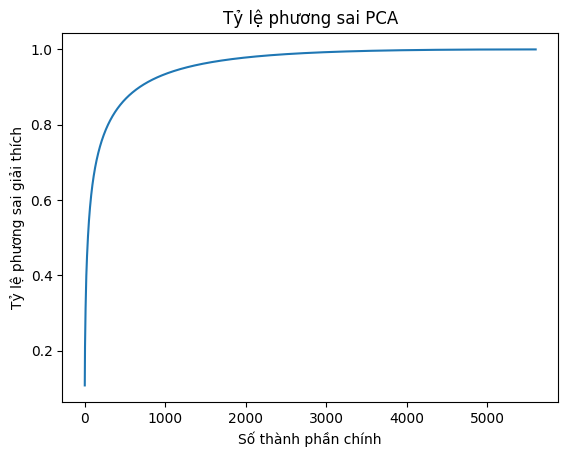

In [16]:
# Ty le phuong sai giai thich
phuong_sai = np.cumsum(pca.explained_variance_ratio_)
graphs_phuong_sai(phuong_sai=phuong_sai)

In [17]:
# Lựa chọn số thành phần sao cho ty le phương sai giai thich >= 0.95
n_components = np.argmax(phuong_sai >= 0.95) + 1
print(n_components)

1226


In [18]:
pca_transform = PCA(n_components=1226)
joblib.dump(pca_transform, './trained/pca_model.pkl')

['./trained/pca_model.pkl']

In [9]:
pca_transform = joblib.load('./trained/pca_model.pkl')
X_train_pca = pca_transform.fit_transform(X_train_scaled)
X_test_pca = pca_transform.transform(X_test_scaled)

### Hàm trực quan hóa kết quả

In [13]:
labels = [i for i in range(len(np.unique(y_train)))]
labels_name = ["Sáo", "Trumpet", "Guitar", "Saxo", "Piano", "Trống", "Vio"]

def graphics_confusion_matrix(cm, labels=labels_name, save_path=None):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Nhãn dự đoán")
    plt.ylabel("Nhãn thực tế")
    plt.title('Confusion Matrix Heatmap')
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Saved confusion matrix to: {save_path}")
    plt.show()

### SVM

In [14]:
print(X_train_pca.shape, X_test_pca.shape, y_train.shape, y_test.shape)

(5600, 1226) (1400, 1226) (5600,) (1400,)


In [23]:
svc = svm.SVC()
parameters = {'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
              'C': [0.1, 1, 10, 100],
              'gamma': ['auto', 'scale'],
              'degree': [3, 4]}

In [23]:
grid_search_svm = GridSearchCV(svc, parameters, cv=5)
grid_search_svm.fit(X_train_pca, y_train)


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [10], 'degree': [3], 'gamma': ['scale'],
                         'kernel': ['rbf']})

In [24]:
print(grid_search_svm.best_params_)

{'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}


In [25]:
joblib.dump(grid_search_svm, "./trained/grid_search_svm.pkl")

['./trained/grid_search_svm.pkl']

In [10]:
best_model_svm = joblib.load("./trained/grid_search_svm.pkl")
y_pred_svm_grid = best_model_svm.predict(X_test_pca)
print(best_model_svm.best_params_)

{'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}


In [11]:
print("Classification Report:")
print(classification_report(y_test, y_pred_svm_grid, digits=4))

Classification Report:
              precision    recall  f1-score   support

           0     0.8199    0.8650    0.8418       200
           1     0.8446    0.8150    0.8295       200
           2     0.9130    0.9450    0.9287       200
           3     0.9282    0.8400    0.8819       200
           4     0.9272    0.9550    0.9409       200
           5     0.9700    0.9700    0.9700       200
           6     0.9505    0.9600    0.9552       200

    accuracy                         0.9071      1400
   macro avg     0.9076    0.9071    0.9069      1400
weighted avg     0.9076    0.9071    0.9069      1400



In [27]:
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm_grid):.3f}")
print(
    f"Precision: {precision_score(y_test, y_pred_svm_grid, average='macro'):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_svm_grid, average='macro'):.3f}")
print(f"F1: {f1_score(y_test, y_pred_svm_grid, average='macro'):.3f}")

Accuracy: 0.908
Precision: 0.908
Recall: 0.908
F1: 0.908


Saved confusion matrix to: ./images/cm_svm


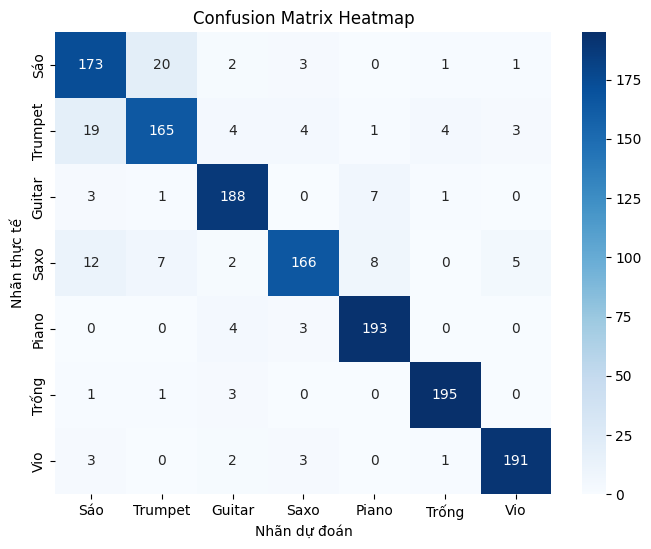

In [28]:
cm_svm = confusion_matrix(y_test, y_pred_svm_grid)
graphics_confusion_matrix(cm=cm_svm, save_path="./images/cm_svm")

### KNN

In [29]:
print(X_train_pca.shape, X_test_pca.shape, y_train.shape, y_test.shape)

(5600, 1226) (1400, 1226) (5600,) (1400,)


In [30]:
knn = KNeighborsClassifier()
parameters_knn = {
    'n_neighbors': list(range(3, 10)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
grid_search_knn = GridSearchCV(knn, parameters_knn, cv=5)
grid_search_knn.fit(X_train_pca, y_train)
print(grid_search_knn.best_params_)

{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}


In [31]:
joblib.dump(grid_search_knn, "./trained/grid_search_knn.pkl")

['./trained/grid_search_knn.pkl']

In [12]:
best_model_knn = joblib.load("./trained/grid_search_knn.pkl")
y_pred_knn_grid = best_model_knn.predict(X_test_pca)

In [13]:
print("Classification Report:")
print(classification_report(y_test, y_pred_knn_grid, digits=4))

Classification Report:
              precision    recall  f1-score   support

           0     0.6708    0.5400    0.5983       200
           1     0.5381    0.6000    0.5674       200
           2     0.8150    0.9250    0.8665       200
           3     0.7967    0.4900    0.6068       200
           4     0.8017    0.9700    0.8778       200
           5     0.9360    0.9500    0.9429       200
           6     0.7511    0.8300    0.7886       200

    accuracy                         0.7579      1400
   macro avg     0.7585    0.7579    0.7498      1400
weighted avg     0.7585    0.7579    0.7498      1400



In [33]:
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn_grid):.3f}")
print(
    f"Precision: {precision_score(y_test, y_pred_knn_grid, average='macro'):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_knn_grid, average='macro'):.3f}")
print(f"F1: {f1_score(y_test, y_pred_knn_grid, average='macro'):.3f}")

Accuracy: 0.761
Precision: 0.762
Recall: 0.761
F1: 0.753


Saved confusion matrix to: ./images/cm_knn


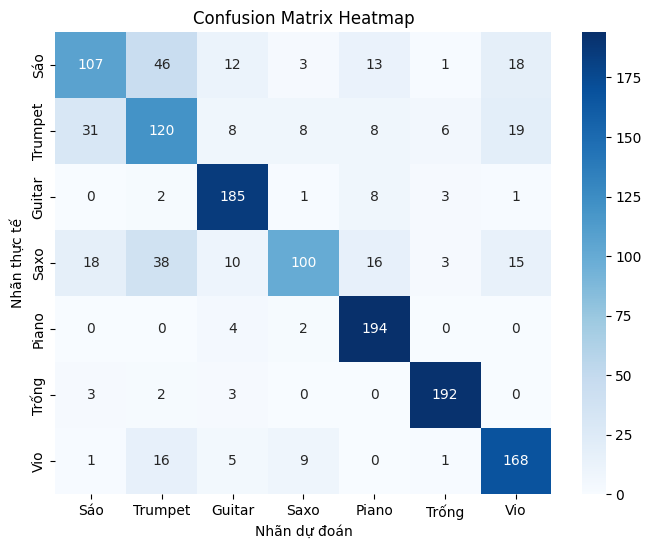

In [34]:
cm_svm = confusion_matrix(y_test, y_pred_knn_grid)
graphics_confusion_matrix(cm=cm_svm, save_path="./images/cm_knn")

### Exploit Knowledge

In [10]:
pca_knn = PCA(n_components=200)
joblib.dump(pca_knn, './trained/pca_knn.pkl')

['./trained/pca_knn.pkl']

In [12]:
X_train_pca_knn = pca_knn.fit_transform(X_train_scaled)
X_test_pca_knn = pca_knn.transform(X_test_scaled)

In [13]:
knn_pca = KNeighborsClassifier(
    metric="euclidean",
    n_neighbors=3,
    weights='distance'
)
knn_pca.fit(X_train_pca_knn, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=3, weights='distance')

In [14]:
y_pred_knn = knn_pca.predict(X_test_pca_knn)

In [15]:
print("Classification Report:")
print(classification_report(y_test, y_pred_knn, digits=4))

Classification Report:
              precision    recall  f1-score   support

           0     0.7625    0.6100    0.6778       200
           1     0.7456    0.6300    0.6829       200
           2     0.8225    0.9500    0.8817       200
           3     0.8412    0.7150    0.7730       200
           4     0.8197    0.9550    0.8822       200
           5     0.9415    0.9650    0.9531       200
           6     0.7888    0.9150    0.8472       200

    accuracy                         0.8200      1400
   macro avg     0.8174    0.8200    0.8140      1400
weighted avg     0.8174    0.8200    0.8140      1400

